In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# load the sales data set
sales_data = pd.read_csv('../../../../Data/SalesData.csv')
sales_data.head()

sales_data = sales_data[sales_data['Category'] == 'Skinbooster'] 


pharmacy_onehot = pd.get_dummies(sales_data['Pharmacy'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded2 = pd.concat([sales_data, pharmacy_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Product'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded3 = pd.concat([sales_data_encoded2, product_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Location'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded = pd.concat([sales_data_encoded3, product_onehot], axis=1)

sales_data_encoded


,Date,Month,Quarter,Year,Qty,Product,Category,Pharmacy,Location,Pharmacy 1,...,"Brazil, USA, Blank, IE, Zimbabwe, Zurich",Ireland & Northern Ireland,London,"NorthEast, Midlands",NorthWest,Outside London M25,Outside London the rest,"Scotland, Newcastle",SouthEast,SouthWest
0,1-11-2015,11,4,2015,2,Injection 14,Skinbooster,Pharmacy 1,London,1,...,0,0,1,0,0,0,0,0,0,0
1,1-11-2015,11,4,2015,1,Injection 14,Skinbooster,Pharmacy 1,London,1,...,0,0,1,0,0,0,0,0,0,0
4,1-11-2015,11,4,2015,4,Injection 14,Skinbooster,Pharmacy 2,"NorthEast, Midlands",0,...,0,0,0,1,0,0,0,0,0,0
15,1-12-2015,12,4,2015,2,Injection 14,Skinbooster,Pharmacy 2,"NorthEast, Midlands",0,...,0,0,0,1,0,0,0,0,0,0
16,1-12-2015,12,4,2015,3,Injection 14,Skinbooster,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68616,1-3-2022,3,1,2022,5,Injection 10,Skinbooster,Pharmacy 5,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
68617,1-3-2022,3,1,2022,7,Injection 10,Skinbooster,Pharmacy 5,SouthWest,0,...,0,0,0,0,0,0,0,0,0,1
68618,1-3-2022,3,1,2022,2,Injection 10,Skinbooster,Pharmacy 5,SouthWest,0,...,0,0,0,0,0,0,0,0,0,1
68619,1-3-2022,3,1,2022,1,Injection 10,Skinbooster,Pharmacy 5,"NorthEast, Midlands",0,...,0,0,0,1,0,0,0,0,0,0


In [2]:
list(sales_data_encoded.columns)

['Date',
 'Month',
 'Quarter',
 'Year',
 'Qty',
 'Product',
 'Category',
 'Pharmacy',
 'Location',
 'Pharmacy 1',
 'Pharmacy 10',
 'Pharmacy 11',
 'Pharmacy 2',
 'Pharmacy 3',
 'Pharmacy 4',
 'Pharmacy 5',
 'Pharmacy 6',
 'Pharmacy 7',
 'Pharmacy 8',
 'Pharmacy 9',
 'Injection 10',
 'Injection 11',
 'Injection 14',
 'Injection 9',
 'Brazil, USA, Blank, IE, Zimbabwe, Zurich',
 'Ireland & Northern Ireland',
 'London',
 'NorthEast, Midlands',
 'NorthWest',
 'Outside London M25',
 'Outside London the rest',
 'Scotland, Newcastle',
 'SouthEast',
 'SouthWest']

In [3]:
# group the data by date and sum the quantities and category columns
sales_data_grouped = sales_data_encoded.groupby('Date').agg({
    'Qty': 'sum',
    'Pharmacy 1' : 'sum',
    'Pharmacy 2' : 'sum',
    'Pharmacy 3' : 'sum',
    'Pharmacy 4' : 'sum',
    'Pharmacy 5' : 'sum',
    'Pharmacy 6' : 'sum',
    'Pharmacy 7' : 'sum',
    'Pharmacy 8' : 'sum',
    'Pharmacy 9' : 'sum',
    'Pharmacy 10' : 'sum',
    'Pharmacy 11' : 'sum',
    'Injection 9' :'sum',
    'Injection 10' :'sum',
    'Injection 11' :'sum',
    'Injection 14' :'sum',
    'Brazil, USA, Blank, IE, Zimbabwe, Zurich' : 'sum',
    'Ireland & Northern Ireland' : 'sum',
    'London' : 'sum',
    'NorthEast, Midlands' : 'sum',
    'NorthWest' : 'sum',
    'Outside London M25' : 'sum',
    'Outside London the rest' : 'sum',
    'Scotland, Newcastle' : 'sum',
    'SouthEast' : 'sum',
    'SouthWest' : 'sum'
    					
})

# reset the index to make date a column again
sales_data_grouped = sales_data_grouped.reset_index()

# create lag features
sales_data_lagged = sales_data_grouped.copy()
for i in range(1, 8):
    sales_data_lagged[f'Qty_lag_{i}'] = sales_data_lagged['Qty'].shift(i)

# print(sales_data_lagged)

# remove rows with missing values
sales_data_lagged.dropna(inplace=True)

sales_data_lagged['Date'] = pd.to_datetime(sales_data_lagged['Date'], format='%d-%m-%Y')

from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(sales_data_lagged.loc[:,sales_data_lagged.columns!='Qty'], sales_data_lagged.loc[:,['Date', 'Qty']], test_size=0.2, random_state=42)
X = sales_data_lagged.loc[(sales_data_lagged['Date'] < '2020-04-01')]
y = sales_data_lagged.loc[(sales_data_lagged['Date'] >= '2020-04-01') & (sales_data_lagged['Date']<= '2021-04-01')]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X.loc[:,X.columns!='Qty']
X_test = y.loc[:,y.columns!='Qty']
y_train = X.loc[:,X.columns=='Qty']
y_test = y.loc[:,y.columns=='Qty']



In [4]:
y

,Date,Qty,Pharmacy 1,Pharmacy 2,Pharmacy 3,Pharmacy 4,Pharmacy 5,Pharmacy 6,Pharmacy 7,Pharmacy 8,...,"Scotland, Newcastle",SouthEast,SouthWest,Qty_lag_1,Qty_lag_2,Qty_lag_3,Qty_lag_4,Qty_lag_5,Qty_lag_6,Qty_lag_7
11,2020-10-01,322,7,32,6,5,18,5,2,0,...,12,9,9,369.0,179.0,6.0,28.0,225.0,51.0,236.0
18,2020-11-01,195,1,18,2,1,13,0,1,0,...,3,5,5,405.0,151.0,13.0,10.0,7.0,319.0,322.0
25,2020-12-01,271,3,16,5,6,17,2,5,0,...,11,4,8,303.0,104.0,1.0,5.0,5.0,367.0,195.0
31,2021-02-01,54,0,7,1,0,5,0,0,0,...,0,0,4,281.0,268.0,4.0,11.0,205.0,271.0,303.0
38,2021-03-01,136,0,15,9,0,8,0,1,0,...,1,11,4,199.0,400.0,7.0,5.0,16.0,327.0,54.0
44,2020-04-01,14,0,2,0,0,6,0,0,0,...,1,1,2,320.0,14.0,4.0,24.0,354.0,136.0,199.0
45,2021-04-01,310,1,30,6,4,20,4,3,1,...,16,10,9,14.0,320.0,14.0,4.0,24.0,354.0,136.0
49,2020-05-01,39,0,5,4,0,0,0,0,0,...,0,0,1,407.0,1.0,19.0,310.0,14.0,320.0,14.0
55,2020-06-01,65,1,5,2,0,8,1,0,0,...,0,4,2,342.0,2.0,1.0,22.0,372.0,39.0,407.0
61,2020-07-01,217,1,26,4,3,18,4,4,0,...,8,4,6,245.0,2.0,6.0,14.0,464.0,65.0,342.0


In [5]:
# train a random forest model

# model = RandomForestRegressor(n_estimators=100, max_depth=5)
# model.fit(train_data.iloc[:, 2:], train_data['Qty'])

criterion = ['squared_error', 'friedman_mse', 'poisson']
max_depth = [5, 10]
min_samples_leaf = [1, 2]
max_features = ['log2', 'sqrt']

random_grid_rfr = {
    'criterion' : criterion,
    'max_depth' : max_depth,
    'min_samples_leaf' : min_samples_leaf,
    'max_features' : max_features
}

rfr = RandomForestRegressor()
rfr_random = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=random_grid_rfr,
    n_iter=10,
    cv=5,
    verbose=5,
    random_state=0
)

In [6]:
rfr_random.fit(X_train.iloc[:, 2:], y_train['Qty'])


# make predictions for the test data
predictions = rfr_random.predict(X_test.iloc[:, 2:])

# calculate the root mean squared error (RMSE) of the predictions
rmse = ((predictions - y_test['Qty']) ** 2).mean() ** 0.5
print('RMSE:', rmse)

print(predictions)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2;, score=0.874 total time=   0.1s
[CV 2/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2;, score=0.967 total time=   0.1s
[CV 3/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2;, score=0.950 total time=   0.2s
[CV 4/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2;, score=0.890 total time=   0.1s
[CV 5/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2;, score=0.920 total time=   0.3s
[CV 1/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1;, score=0.899 total time=   0.1s
[CV 2/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1;, score=0.957 total time=   0.1s
[CV 3/5] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1;, sc

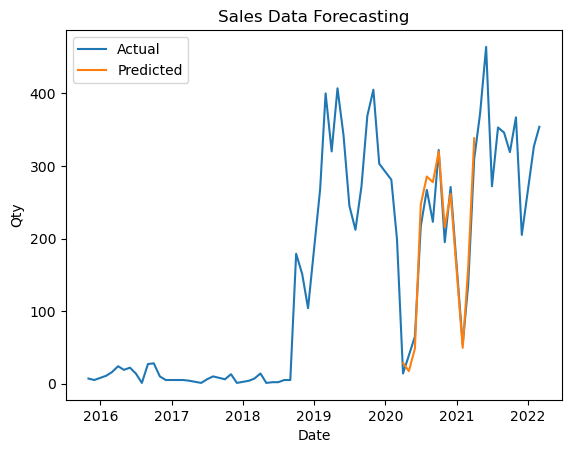

In [7]:

sales_data_lagged['predicted_quantity'] = pd.Series(predictions, index=y_test.index)
sales_data_lagged= sales_data_lagged.sort_values(by=['Date'])

# plot the actual and predicted quantities against date
plt.plot(sales_data_lagged['Date'], sales_data_lagged['Qty'], label='Actual')
plt.plot(sales_data_lagged['Date'], sales_data_lagged['predicted_quantity'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Sales Data Forecasting')
plt.legend()
plt.show()

In [8]:
rfr_random.best_params_

{'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'criterion': 'friedman_mse'}

[array(['2020-10-01T00:00:00.000000000', '2020-11-01T00:00:00.000000000',
       '2020-12-01T00:00:00.000000000', '2021-02-01T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000', '2020-04-01T00:00:00.000000000',
       '2021-04-01T00:00:00.000000000', '2020-05-01T00:00:00.000000000',
       '2020-06-01T00:00:00.000000000', '2020-07-01T00:00:00.000000000',
       '2020-08-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000'],
      dtype='datetime64[ns]'), array([322, 195, 271,  54, 136,  14, 310,  39,  65, 217, 267, 223],
      dtype=int64), array([319.94, 215.54, 261.62,  49.36, 159.48,  28.57, 338.14,  17.24,
        48.51, 246.94, 285.42, 277.59])]


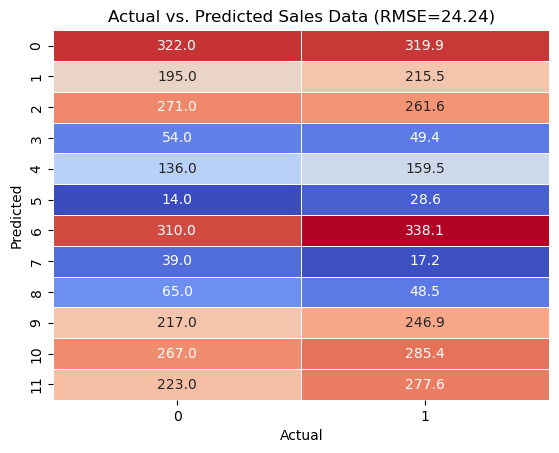

In [9]:
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
import math

matrix_data = np.column_stack((y_test['Qty'].values, predictions))

#print((test_data['Qty'].values, predictions))
print([X_test['Date'].values, y_test['Qty'].values, predictions])

# calculate the mean squared error
mse = mean_squared_error(y_test['Qty'], predictions)
rmse = math.sqrt(mse)

# plot the matrix using seaborn's heatmap function
sns.heatmap(matrix_data, annot=True, fmt='.1f', cmap='coolwarm', linewidths=.5, cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Sales Data (RMSE={rmse:.2f})')
plt.show()